In [32]:
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
import os
import math
import torch.nn as nn
from training_scripts.sMNIST.model import rnn
from training_scripts.sMNIST.dataset import MnistDataModule
import training_scripts.sMNIST.default_config as config
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import Normalize
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.profilers import PyTorchProfiler

torch.set_float32_matmul_precision("medium")

In [22]:
PERMUTED = True
folder_name = "../../tb_logs/ortho_init/psMNIST_64"
model_name = "psMNIST_128_0.02_0.005_0.1_lr_0.01"
version = 0
seed = 73

In [23]:
def load_model(epoch_number=None, model_name=None, folder_name=None, version=0):
    checkpoint_folder = f'{folder_name}/{model_name}/version_{version}/checkpoints/'
    hparams_path = f'{folder_name}/{model_name}/version_{version}/hparams.yaml'
    checkpoint_files = os.listdir(checkpoint_folder)
    epoch_idx = [int(file.split('epoch=')[1].split('-')[0]) for file in checkpoint_files]

    if epoch_number is not None:
        # If epoch number is provided, find the index of that epoch
        max_idx = epoch_idx.index(epoch_number)
    else:
        # If epoch number is not provided, find the index of the max epoch
        max_idx = epoch_idx.index(max(epoch_idx))

    checkpoint_path = os.path.join(checkpoint_folder, checkpoint_files[max_idx])
    # print(checkpoint_path)
    model = rnn.load_from_checkpoint(checkpoint_path=checkpoint_path, map_location='cpu', hparams_file=hparams_path)
    model.eval()
    return model


# model = load_model()

# epoch_no = 100
# model = load_model(epoch_no)

In [24]:
logger = TensorBoardLogger(folder_name, name="Inference")
dm = MnistDataModule(
    data_dir=config.DATA_DIR,
    batch_size=1000,
    num_workers=2,
    permuted=PERMUTED,
    seed=seed
)
# calculate training accuracy using pytorch lightning
trainer = pl.Trainer(
    logger=logger,
    max_epochs=1
)

epoch_no = None
# epoch_no = 0
model = load_model(epoch_no, model_name, folder_name, version)

trainer.test(model, datamodule=dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7960000038146973
        test_loss           0.6219533085823059
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.7960000038146973, 'test_loss': 0.6219533085823059}]

In [25]:
class TestAccuracyCallback(Callback):
    def __init__(self):
        super().__init__()
        self.test_acc = None

    def on_test_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        self.test_acc = metrics.get('test_acc', None)

test_acc_callback = TestAccuracyCallback()
# check the test accuracy for models with epoch numbers between 90 and 130
logger = TensorBoardLogger(folder_name, name="Inference")
dm = MnistDataModule(
    data_dir=config.DATA_DIR,
    batch_size=10000,
    num_workers=2,
    permuted=PERMUTED,
    seed=seed
)
trainer = pl.Trainer(
    logger=logger,
    max_epochs=1,
    callbacks=[test_acc_callback]
)
epochs = list(range(100, 305))
test_accuracies = []
for epoch_no in epochs:
    model = load_model(epoch_no, model_name, folder_name, version)
    trainer.test(model, datamodule=dm)
    test_accuracies.append(test_acc_callback.test_acc)

# plot the test accuracy vs epoch number
# bring test_accuracies to cpu
test_accuracies = [acc.cpu().numpy() for acc in test_accuracies]
plt.plot(epochs, test_accuracies)
plt.xlabel('Epoch Number')
plt.ylabel('Test Accuracy')
plt.show()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


ValueError: 280 is not in list

In [26]:
# print the epoch number corresponding to the best accuracy
max_acc = max(test_accuracies)
max_acc_epoch = epochs[test_accuracies.index(max_acc)]

print(f"Best accuracy: {max_acc} at epoch number: {max_acc_epoch}")

ValueError: max() arg is an empty sequence

In [27]:
logger = TensorBoardLogger(folder_name, name="Inference")
dm = MnistDataModule(
    data_dir=config.DATA_DIR,
    batch_size=1000,
    num_workers=2,
    permuted=PERMUTED,
    seed=seed
)
# calculate training accuracy using pytorch lightning
trainer = pl.Trainer(
    logger=logger,
    max_epochs=1
)

epoch_no = None
# epoch_no = 168
model = load_model(epoch_no, model_name, folder_name, version)

trainer.test(model, datamodule=dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7960000038146973
        test_loss           0.6219533085823059
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.7960000038146973, 'test_loss': 0.6219533085823059}]

['hp_metric', 'test_acc', 'test_loss', 'epoch']


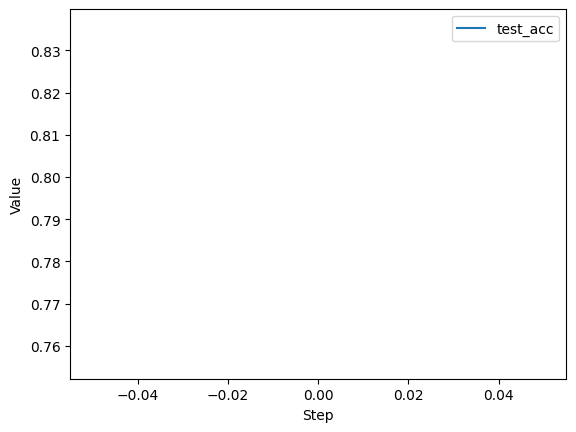

In [28]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

event_acc = EventAccumulator(logger.log_dir)
event_acc.Reload()

tags = event_acc.Tags()['scalars']
print(tags)
selected_tag = 'test_acc'
data = event_acc.Scalars(selected_tag)

# Extract steps and values
steps = [entry.step for entry in data]
values = [entry.value for entry in data]

# Plot the data using matplotlib
plt.plot(steps, values, label=selected_tag)
plt.xlabel('Step')
plt.ylabel('Value')
plt.legend()
plt.show()

In [29]:
# plot the evolution of activations
y_example = torch.stack(model.activations["y"], dim=1).cpu()
a_example = torch.stack(model.activations["a"], dim=1).cpu()
b0_example = torch.stack(model.activations["b0"], dim=1).cpu()
b1_example = torch.stack(model.activations["b1"], dim=1).cpu()
print(a_example.shape)

torch.Size([1000, 785, 64])


In [30]:
y_example.shape

torch.Size([1000, 785, 64])

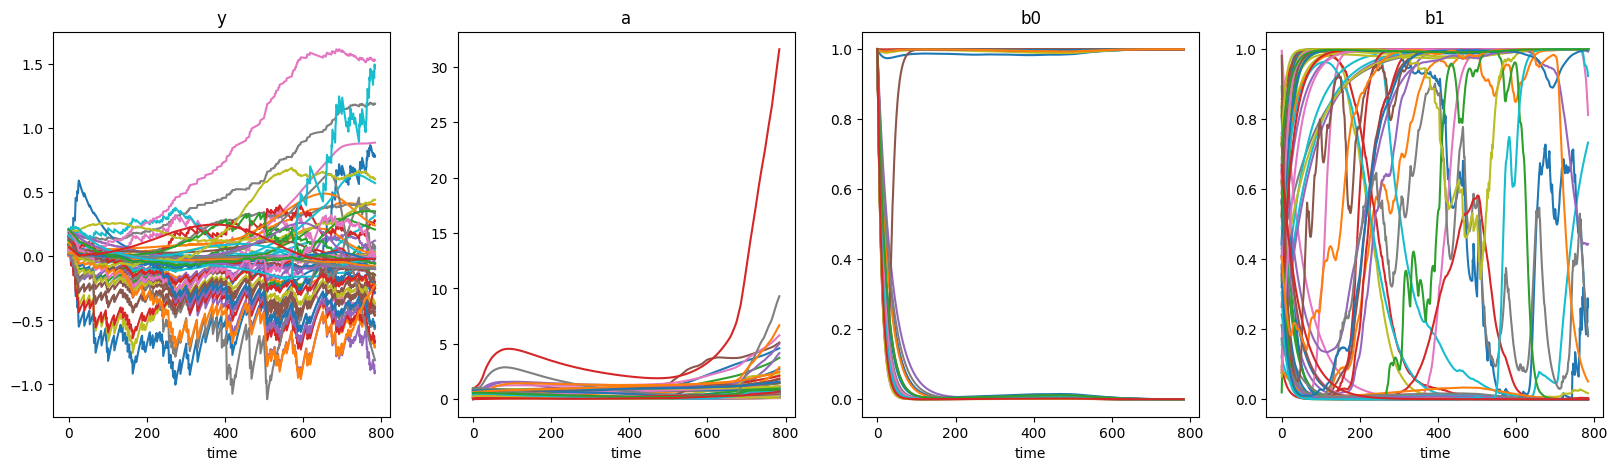

In [31]:
# plot y_example[0, :, :] and a_example[0, :, :] side by side
fig, axs = plt.subplots(1, 4)
# increase the figsze
batch_idx = 990
fig.set_size_inches(20, 5)
axs[0].plot(y_example[batch_idx, :, :])
axs[0].set_title('y')
axs[0].set_xlabel('time')

axs[1].plot(a_example[batch_idx, :, :])
axs[1].set_title('a')
axs[1].set_xlabel('time')

axs[2].plot(b0_example[batch_idx, :, :])
axs[2].set_title('b0')
axs[2].set_xlabel('time')

axs[3].plot(b1_example[batch_idx, :, :])
axs[3].set_title('b1')
axs[3].set_xlabel('time')
plt.show()

In [18]:
print(model.activations["target"][0][batch_idx])
print(model.activations["preds"][0][batch_idx])

tensor(2, device='cuda:0')
tensor(6, device='cuda:0')


In [19]:
# # torch save y_example, a_example, b0_example, b1_example and so on
# torch.save(y_example, 'y_examplep.pt')
# torch.save(a_example, 'a_examplep.pt')
# torch.save(b0_example, 'b0_examplep.pt')
# torch.save(b1_example, 'b1_examplep.pt')


In [20]:
"""Code for saving these figures"""
file_path = '/scratch/sr6364/organics-ml/plots/'+ model_name + '/'
os.makedirs(file_path, exist_ok=True)

for batch_idx in range(10):
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    
    axs[0].plot(y_example[batch_idx, :, :])
    axs[0].set_title('y')
    axs[0].set_xlabel('time')

    axs[1].plot(a_example[batch_idx, :, :])
    axs[1].set_title('a')
    axs[1].set_xlabel('time')

    axs[2].plot(b0_example[batch_idx, :, :])
    axs[2].set_title('b0')
    axs[2].set_xlabel('time')

    axs[3].plot(b1_example[batch_idx, :, :])
    axs[3].set_title('b1')
    axs[3].set_xlabel('time')

    plt.tight_layout()
    file_name = f'dynamics_batch_{batch_idx}.png'
    plt.savefig(file_path + file_name, bbox_inches='tight', format='png', dpi=600)
    plt.close(fig)  # Close the figure to free memory

In [17]:
# y = y_example[batch_idx, :, :].clone()
# a = a_example[batch_idx, :, :]
# b0 = b0_example[batch_idx, :, :]
# b1 = b1_example[batch_idx, :, :]

# # save these tensors
# torch.save(y, 'y_smnist.pt')
# torch.save(a, 'a.pt')
# torch.save(b0, 'b0.pt')
# torch.save(b1, 'b1.pt')




In [14]:
# y.shape

torch.Size([785, 64])

In [10]:
t = 400
# find indices of b0_example where the value is less than 0.6 at t timestep
indices = torch.where(b0_example[batch_idx, t, :] < 0.5)
print(indices)

(tensor([  0,   2,   3,   6,  10,  11,  12,  13,  16,  17,  18,  19,  22,  24,
         26,  30,  32,  33,  34,  35,  36,  39,  41,  42,  43,  45,  46,  50,
         51,  53,  54,  55,  56,  57,  58,  61,  62,  64,  65,  67,  69,  71,
         72,  73,  75,  76,  77,  79,  80,  83,  85,  86,  87,  90,  91,  96,
         98,  99, 100, 103, 106, 107, 108, 109, 110, 113, 114, 115, 117, 121,
        122, 123, 125, 126, 127]),)


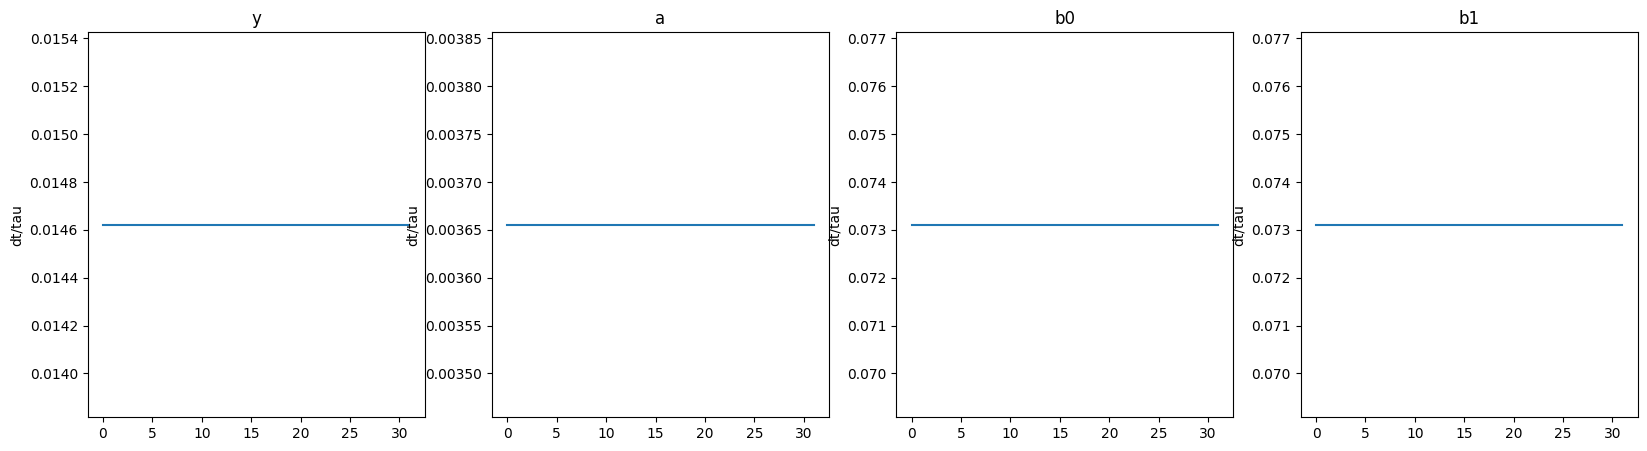

In [21]:
fig, axs = plt.subplots(1, 4)
# increase the figsze
batch_idx = 10
fig.set_size_inches(20, 5)
axs[0].plot(model.org.dt_tauy().detach())
axs[0].set_title('y')
axs[0].set_ylabel('dt/tau')

axs[1].plot(model.org.dt_taua().detach())
axs[1].set_title('a')
axs[1].set_ylabel('dt/tau')

axs[2].plot(model.org.dt_taub0().detach())
axs[2].set_title('b0')
axs[2].set_ylabel('dt/tau')

axs[3].plot(model.org.dt_taub1().detach())
axs[3].set_title('b1')
axs[3].set_ylabel('dt/tau')
plt.show()


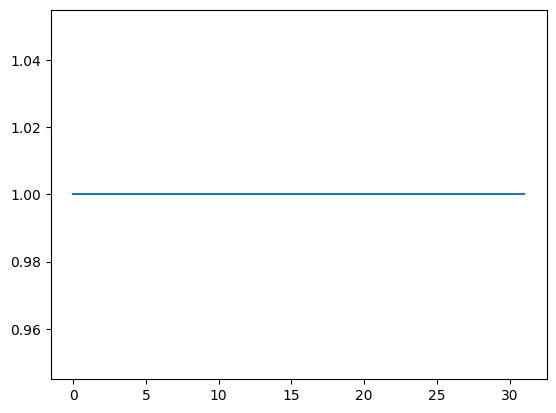

In [75]:
sigma = model.org.sigma.detach()
# plot it
plt.plot(abs(sigma))
# plot indices
plt.show()

We now analyze the dynamics of a and why they grow so much towards the end

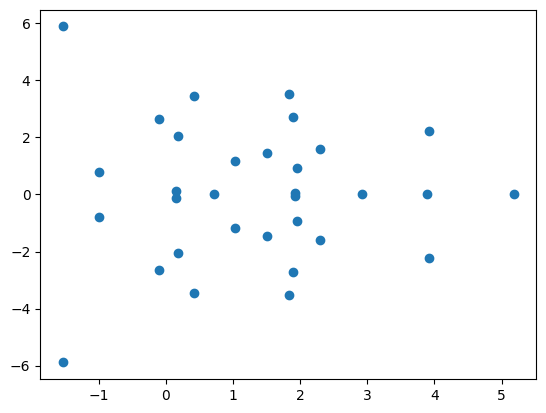

In [76]:
Wr = model.org.Wr().detach().cpu()

# calculate eigenvalues of Way
eigvals = torch.linalg.eigvals(Wr)
# plot the real and complex parts of the eigenvalues
plt.scatter(eigvals.real, eigvals.imag)
# xlim 0, 1
# plt.xlim(0, 5)
plt.show()

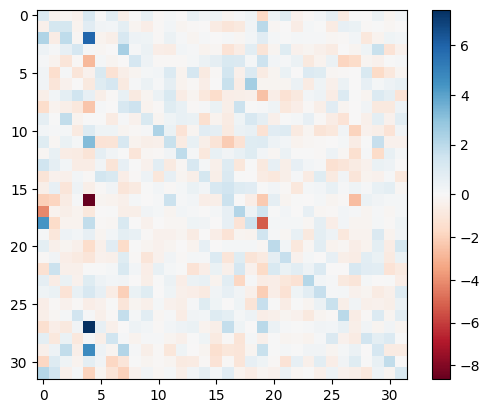

In [77]:
# Normalize the colormap based on your data range and center point
norm = TwoSlopeNorm(vmin=torch.min(Wr), vcenter=0.0, vmax=torch.max(Wr))
cmap = colormaps.get_cmap('RdBu')
# imshow the matrix Wr
plt.imshow(Wr, cmap=cmap, norm=norm)
plt.colorbar()
plt.show()

In [78]:
# Singular values of Wr
U, S, V = torch.svd(Wr)

# Print the singular values in non-scientific notation
print(" ".join(f"{value:.2f}," for value in S))

16.30, 10.76, 8.27, 7.30, 6.70, 6.23, 5.32, 5.09, 4.80, 4.53, 4.33, 4.14, 3.98, 3.49, 3.35, 3.13, 2.92, 2.76, 2.48, 2.38, 2.12, 1.88, 1.66, 1.37, 1.25, 1.05, 0.96, 0.69, 0.52, 0.28, 0.13, 0.04,


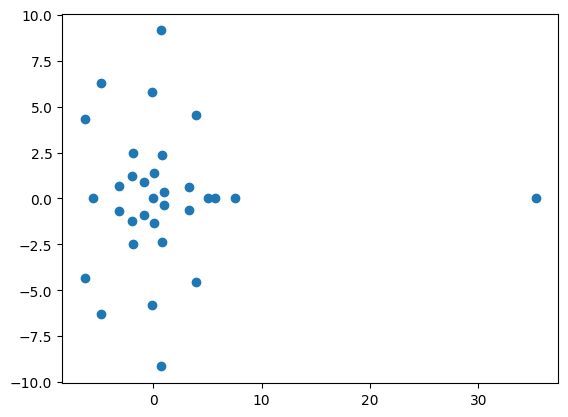

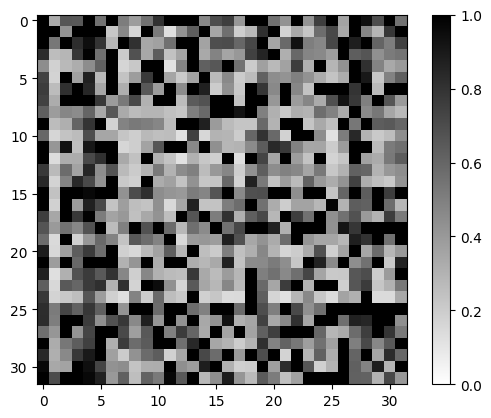

In [79]:
Way = model.org.Way().detach().cpu()


# calculate eigenvalues of Way
eigvals = torch.linalg.eigvals(Way)
# plot the real and complex parts of the eigenvalues

plt.scatter(eigvals.real, eigvals.imag)
# xlim 0, 1
# plt.xlim(0, 5)
plt.show()


vmin = 0
vmax = 1.0
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = colormaps.get_cmap('binary')
# imshow the matrix Wr
plt.imshow(Way, cmap=cmap, norm=norm)
plt.colorbar()
plt.show()

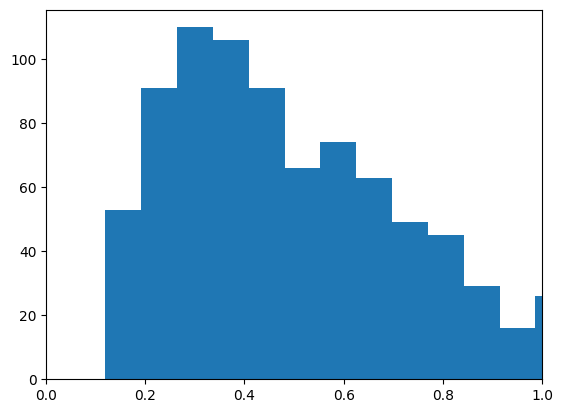

In [84]:
# Remove the largest value in Way
Way = model.org.Way().detach().cpu()
Way = Way.flatten()
# W_flat = Way[Way != Way.max()]

plt.hist(Way, bins=100)
# plt.xlim(0, 1)
plt.show()


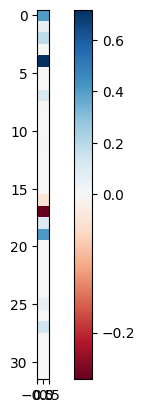

In [81]:
Wzx = model.org.Wzx().detach().cpu()
norm = TwoSlopeNorm(vmin=torch.min(Wzx), vcenter=0.0, vmax=torch.max(Wzx))
cmap = colormaps.get_cmap('RdBu')
# imshow the matrix Wr
# increase figure size
plt.imshow(Wzx, cmap=cmap, norm=norm)
plt.colorbar()
plt.show()

In [24]:
# find how many of Wzx are betwwen 0.1 and -0.1
Wzx = model.org.Wzx().detach().cpu()
Wzx = Wzx.flatten()
W_flat = Wzx[(Wzx > -0.1) & (Wzx < 0.1)]
print(len(W_flat))
indices_new = torch.where((Wzx > -0.5) & (Wzx < 0.5))
print(indices)
print(indices_new)
# plot indices and indices_new
plt.plot(indices)
plt.plot(indices_new)
plt.show()

0


NameError: name 'indices' is not defined

Now we figure out why is a gowing so much towards the end of the sequence? To test this we calculate the RHS of a and how much does each term contribute.

In [35]:
# give me an example image from the test set
test_loader = dm.test_dataloader()
x, y = next(iter(test_loader))
x = x[0, :, :, :].squeeze()
# x = x.reshape(1, 28, 28)
x = x.reshape(1, 784, 1)
# repeat x along the first dimension
# x = x.repeat(2, 1, 1)
y = model.y0.repeat(x.size(0), 1)
a = model.a0.repeat(x.size(0), 1)
b = model.b0.repeat(x.size(0), 1)

import collections
activation = collections.defaultdict(list)

AttributeError: 'rnn' object has no attribute 'b0'

In [21]:
for i in range(x.size(1)):
    x_t = x[:, i, :]
    activation["x"].append(x_t)

    z = F.linear(x_t, model.org.Wzx, bias=None)
    # make z to be norm 1 only if norm is positive
    # norm_z = torch.norm(z, dim=1, keepdim=True) + 1e-5
    # z = (z / norm_z) * (torch.norm(x_t, dim=1, keepdim=True) / math.sqrt(model.org.input_size))


    activation["z"].append(z)

    y_hat = F.relu(F.linear(y, model.org.Wr(), bias=None))
    activation["y_hat"].append(y_hat)

    B0 = model.org.B0()
    B1 = model.org.B1(x_t)
    activation["B0"].append(B0)
    activation["B1"].append(B1)

    # Update the input gain loss
    # model.input_gain_mse_loss = model.input_gain_mse(B0, B1)

    # Define the time parameters
    dt_y = model.org.Dt_y()
    dt_a = model.org.Dt_a()
    dt_b1 = model.org.Dt_b1()

    # Define the normalization weight matrix
    Way = model.org.Way()
    # Way = torch.ones(128, 128)

    # Integrate the diff. equation by one step and find the activations
    b_new = b + dt_b1 * (- b + B1)
    y_new = y + dt_y * (- y + b * z + (1 - model.org.get_activation_a(a)) * y_hat)
    a_new = a + dt_a * (
        - a
        + model.org.sigma**2 * B0**2
        + F.linear(model.org.get_activation_y(y) * torch.relu(a), Way, bias=None)
        # + F.relu(F.linear(x_t, model.org.Wax, bias=None))
    )
    
    activation["a_constant"].append(model.org.sigma**2 * B0**2)
    activation["a_recurrent"].append(F.linear(model.org.get_activation_y(y) * torch.relu(a), Way, bias=None))
    # activation["a_input"].append(F.relu(F.linear(x_t, model.org.Wax, bias=None)))
    
    activation["a"].append(a)
    activation["y"].append(y)
    activation["b"].append(b)
    
    a = a_new
    y = y_new
    b = b_new

In [22]:
z.shape

torch.Size([1, 256])

In [23]:
norm_z = torch.norm(z, dim=1, keepdim=True)
print(norm_z.shape)

torch.Size([1, 1])


In [24]:
for key in activation.keys():
    # check if dim of activation[key] is 1
    if len(activation[key][0].shape) == 1:
        activation[key] = torch.stack(activation[key], dim=0).detach().cpu()
    else:
        activation[key] = torch.squeeze(torch.stack(activation[key], dim=1).detach().cpu(), 0)

# reshape the input
activation["x"] = activation["x"].reshape(28, 28)

IndexError: list index out of range

In [25]:
print(activation["x"].shape)
print(activation["z"].shape)
print(activation["y_hat"].shape)
print(activation["B0"].shape)
print(activation["B1"].shape)
print(activation["a_constant"].shape)
print(activation["a_recurrent"].shape)
print(activation["a_input"].shape)
print(activation["a"].shape)
print(activation["y"].shape)
print(activation["b"].shape)

torch.Size([786, 1])
torch.Size([786, 256])
torch.Size([786, 256])
torch.Size([786, 256])
torch.Size([786, 256])
torch.Size([785, 256])
torch.Size([785, 256])


AttributeError: 'list' object has no attribute 'shape'

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

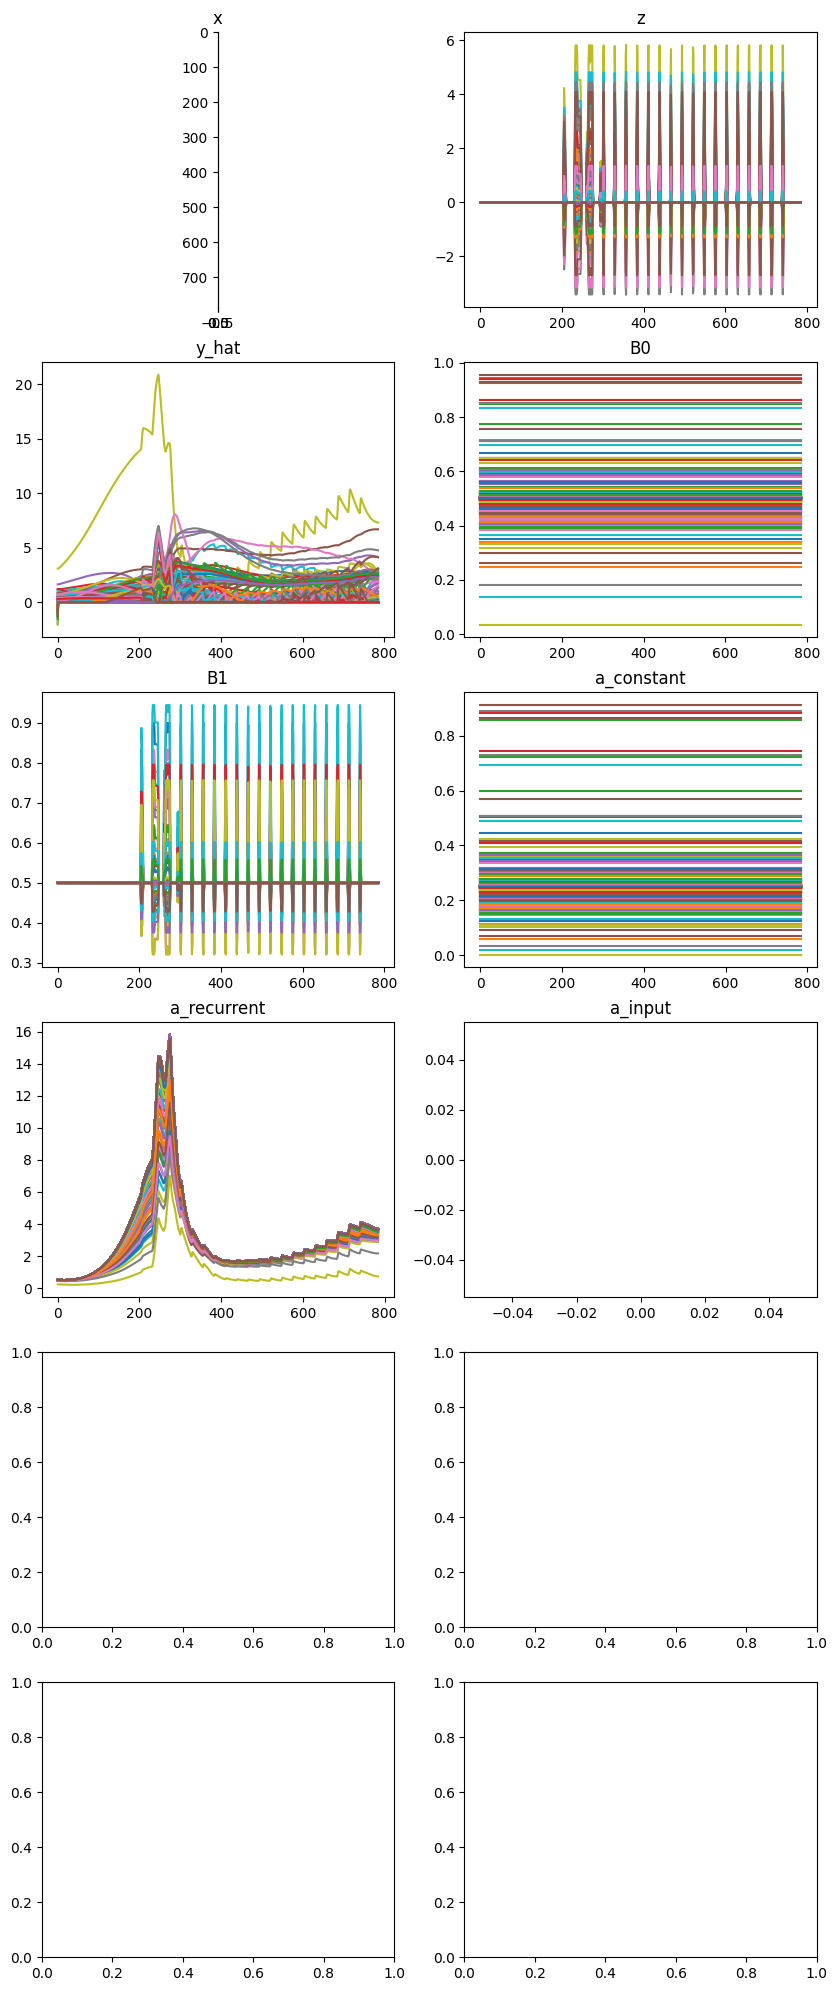

In [26]:
# print all of the activations in a single figure along with titles for different activations
# calculate teh norm of z
norm_z = torch.norm(activation["z"], dim=1)


fig, axs = plt.subplots(6, 2)
fig.set_size_inches(10, 25)
axs[0, 0].imshow(activation["x"])
axs[0, 0].set_title("x")
axs[0, 1].plot(activation["z"])
axs[0, 1].set_title("z")
axs[1, 0].plot(activation["y_hat"])
axs[1, 0].set_title("y_hat")
axs[1, 1].plot(activation["B0"])
axs[1, 1].set_title("B0")
axs[2, 0].plot(activation["B1"])
axs[2, 0].set_title("B1")
axs[2, 1].plot(activation["a_constant"])
axs[2, 1].set_title("a_constant")
axs[3, 0].plot(activation["a_recurrent"])
axs[3, 0].set_title("a_recurrent")
axs[3, 1].plot(activation["a_input"])
axs[3, 1].set_title("a_input")
axs[4, 0].plot(activation["a"])
axs[4, 0].set_title("a")
axs[4, 1].plot(activation["y"])
axs[4, 1].set_title("y")
axs[5, 0].plot(activation["b"])
axs[5, 0].set_title("b")
axs[5, 1].plot(norm_z)
axs[5, 1].set_title("norm_z")
plt.show()


In [53]:
ar = activation["a_recurrent"]
print(ar.shape)

torch.Size([28, 128])


In [54]:
# find the index of max value in ar
max_idx = torch.argmax(ar[-1, :])
print(max_idx)
idx = max_idx
W = model.org.Way().detach().cpu()
# calculate the norm of each row in W
norm_W = torch.norm(W, dim=1)

tensor(8)


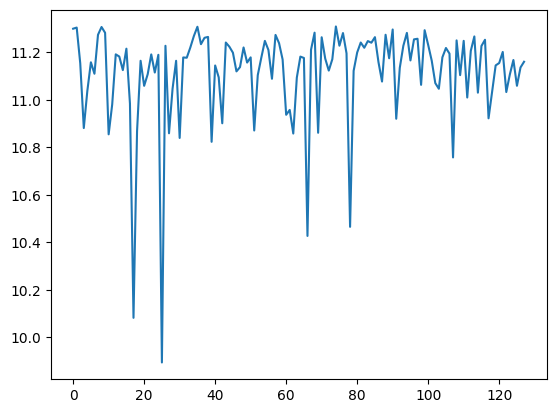

In [55]:
plt.plot(norm_W)
plt.show()

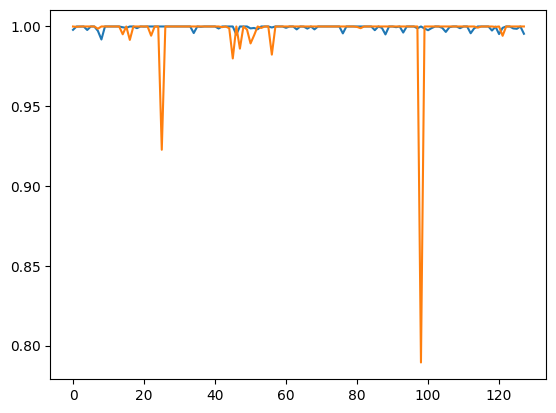

In [56]:
plt.plot(W[idx, :])
plt.plot(W[idx+1, :])
plt.show()